In [1]:
#必要なライブラリのインポート
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#画像の読み込み・保存
img = []
for i in range(1,1585):
    image = cv2.imread('images/%d.jpg'%i)
    img.append(image)
    cv2.imwrite('leaf_images/%d.jpg'%(i-1), img[i-1])

In [3]:
#保存した画像の読み込み
img = []
for i in range(1584):
    image = cv2.imread('leaf_images/%d.jpg'%i)
    img.append(image)

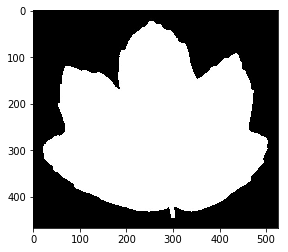

In [4]:
plt.imshow(img[0])

In [5]:
#画像をリサイズする関数の定義
def resize(image):
    side = 100
    
    if image.shape[0] >= image.shape[1]:
        max_side = image.shape[0]
    else:
        max_side = image.shape[1]
        
    scale = side / max_side
    height, width = image.shape
    size = (int(width*scale), int(height*scale))
    resized_img = cv2.resize(image, size)

    height, width = resized_img.shape

    if width >= height:
        pad = np.zeros([int((width-height)/2),width])
        new_img = np.vstack((pad, resized_img, pad))
    else:
        pad = np.zeros([height, int((height-width)/2)])
        new_img = np.hstack((pad, resized_img, pad))
        
    new_img = cv2.resize(new_img, (100,100))
    
    return new_img

In [6]:
#画像の前処理
for i in range(1584):
    img[i] = cv2.cvtColor(img[i], cv2.COLOR_RGB2GRAY) #グレースケール化
    img[i] = resize(img[i]) #リサイズ

In [7]:
img[0].shape

(100, 100)

In [20]:
#データの読み込み
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [21]:
#トレーニング用データの作成
train_img = []
for i in df_train['id']:
    image = img[i-1]
    train_img.append(image)
    
#テスト用データの作成    
test_img = []
for i in df_test['id']:
    image = img[i-1]
    test_img.append(image)

In [22]:
labels_num = pd.get_dummies(df_train['species'])
labels_num = np.array(labels_num)

labels = []
for i in range(990):
    for j in range(99):
        if labels_num[i,j] == 1:
            labels.append(j)

In [23]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(train_img,
                                                    labels, test_size=0.3, random_state=0)

In [24]:
type(X_train)

list

In [25]:
len(X_train)

693

In [26]:
def augmentation1(image):
    # 左右反転のノイズを加える
    image = np.fliplr(image)
    
    return image

In [27]:
def augmentation2(image):
    # 左右反転のノイズを加える
    image = np.fliplr(image)
    
    if np.random.rand() > 0.5:
        #90度回転させる
        size = (image.shape[0], image.shape[1])
        # 画像の中心位置(x, y)
        center = (int(size[0]/2), int(size[1]/2))
        # 回転させたい角度
        angle = 90
        # 拡大比率
        scale = 1.0
        # 回転変換行列の算出
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        # 並進移動
        image = cv2.warpAffine(image, rotation_matrix, size)
        
    return image

In [28]:
def augmentation3(image):
    # 左右反転のノイズを加える
    image = np.fliplr(image)
       
    if np.random.rand() > 0.5:    
        # 左右どちらかに30度回転させる
        size = (image.shape[0], image.shape[1])
        # 画像の中心位置(x, y)
        center = (int(size[0]/2), int(size[1]/2))
        # 回転させたい角度
        angle = -90
        # 拡大比率
        scale = 1.0
        # 回転変換行列の算出
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        # 並進移動
        image = cv2.warpAffine(image, rotation_matrix, size)
    
    return image

In [29]:
def augmentation4(image):
    # 画像サイズを一度拡大する
    # (画像, 変換後のサイズ, 横の拡大比率, 縦の拡大比率)
    resized = cv2.resize(image, None, fx=0.8, fy=0.8)

    # 変換前後のshapeを指定する
    height_1, width_1,  = image.shape # 元画像と同じサイズにするので､そのサイズを取得
    height_2, width_2,  = resized.shape # 拡大後の画像のサイズを取得

    # x、y軸それぞれの切り取り開始点の決定
    # ピクセルの指定は整数になるようにする
    x =  int((width_1 - width_2) / 2)
    y =  int((height_1 - height_2) / 2)

    pad_x = np.zeros([height_2, x])
    pad_y = np.zeros([y, width_1])
    #切り取り開始点から元の画像分のサイズを切り取る
    resized = np.hstack((pad_x, resized, pad_x))
    resized = np.vstack((pad_y, resized, pad_y))
    
    return resized

In [30]:
#画像のAugmentation
augmented1 = []
for i in range(len(X_train)):
    image = augmentation1(X_train[i])
    augmented1.append(image)
    
augmented2 = []
for i in range(len(X_train)):
    image = augmentation2(X_train[i])
    augmented2.append(image)
    
augmented3 = []
for i in range(len(X_train)):
    image = augmentation3(X_train[i])
    augmented3.append(image)
    
augmented4 = []
for i in range(len(X_train)):
    image = augmentation4(X_train[i])
    augmented4.append(image)

In [31]:
for i in range(len(augmented1)):
    X_train.append(augmented1[i])
    y_train.append(y_train[i])
    
for i in range(len(augmented2)):
    X_train.append(augmented2[i])
    y_train.append(y_train[i])
    
for i in range(len(augmented3)):
    X_train.append(augmented3[i])
    y_train.append(y_train[i])
    
for i in range(len(augmented4)):
    X_train.append(augmented4[i])
    y_train.append(y_train[i])

In [32]:
len(X_train)

3465

In [33]:
len(y_train)

3465

In [34]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [35]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

In [36]:
X_train.shape

(3465, 100, 100)

In [37]:
y_train.shape

(3465,)

In [38]:
X_train = X_train.reshape(-1, 10000)
X_test = X_test.reshape(-1, 10000)

In [39]:
X_train.shape

(3465, 10000)

In [40]:
X_test.shape

(297, 10000)

In [41]:
X_train /= 255
X_test /= 255

In [42]:
X_train.max()

1.0

In [43]:
# 必要なモジュールの読み込み
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import computational_graph # グラフを出力するパッケージ
from chainer.datasets import tuple_dataset, TransformDataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

C:\Users\Jin Sakuma\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
# ニューラルネットワークの定義
# 4層のDeep Neural Network
# chainerのChainクラスを継承
class MLP(chainer.Chain):
    ''' ニューラルネットの構造を定義'''
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(10000, 7000)  # 第1層からの入力784､第2層への出力900
            self.l2=L.Linear(7000, 1000) # 第2層からの入力600､第3層への出力1000
            self.l3=L.Linear(1000, 500) # 第3層からの入力1000､第4層への出力500
            self.l4=L.Linear(500, 99)   # 第4層からの入力500､出力層への出力10
        
    
    ''' ニューラルネットの計算規則を定義'''
    def __call__(self, X):
        h1 = F.relu(self.l1(X))  # 1つめの隠れ層からの出力を計算
        h2 = F.relu(self.l2(h1)) # 2つめの隠れ層からの出力を計算
        h3 = F.relu(self.l3(h2)) # 3つめの隠れ層からの出力を計算
        return self.l4(h3)       # 出力層への入力を返す

In [45]:
# 分類器インスタンスの生成
# MLPクラスのインスタンスを引数として渡す
model = L.Classifier(MLP())

In [46]:
# gpuの使用の有無を指定
# 今回はCPUを想定しているため-1に指定
gpu = -1 

In [47]:
# cupyの使用の有無を指定
if gpu >= 0:
    xp = cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
else:
    xp = np

In [48]:
# optimizerの定義
optimizer = chainer.optimizers.SGD()  # 今回はSGDを利用
optimizer.setup(model)                # モデルを読み込ませる

In [49]:
# ミニバッチに含まれるサンプル数を指定
# データからサンプルを100個ずつ取り出して学習する
batch_size = 100

In [50]:
# epoch数を指定
n_epoch = 20

In [51]:
# X_trainとy_trainをTupleDatasetにまとめる
train = tuple_dataset.TupleDataset(X_train, y_train)

In [52]:
# train_iterを生成
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)

In [53]:
# Updataerを生成
# 今回はCPUの利用を想定
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)

In [54]:
# trainerの定義
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')

In [55]:
# testデータをTupleDatasetに変換
test = tuple_dataset.TupleDataset(X_test,y_test)

In [56]:
# test_iterを生成
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)

In [57]:
# Evaluatorクラスをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter, model))

In [58]:
# ログファイルを作成する機能を追加
trainer.extend(extensions.LogReport())

In [59]:
# 学習状況の報告を逐一出力する機能を追加
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [60]:
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [61]:
# 指定した内容で学習を実行
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           4.50715     0.0385714      4.44846               0.0336426                 
2           4.31013     0.0825714      4.30869               0.0369759                 
3           4.1284      0.101471       4.14458               0.0435395                 
4           3.93644     0.126857       3.94628               0.0805155                 
5           3.73867     0.167714       3.80355               0.0772852                 
6           3.57953     0.192059       3.5511                0.134674                  
7           3.40715     0.218857       3.39974               0.16488                   
8           3.26388     0.239714       3.22811               0.174777                  
9           3.1269      0.268235       3.11974               0.174983                  
10          3.01411     0.277143       2.99808               0.215189                  
11          2.88153     0.311429  

In [193]:
# ReportPlotによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

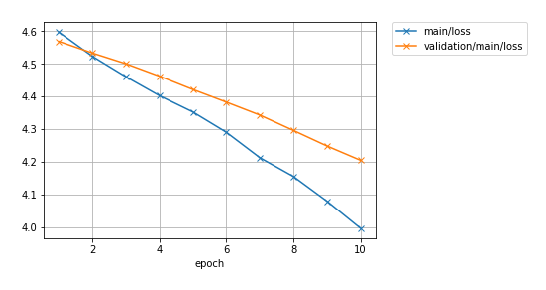

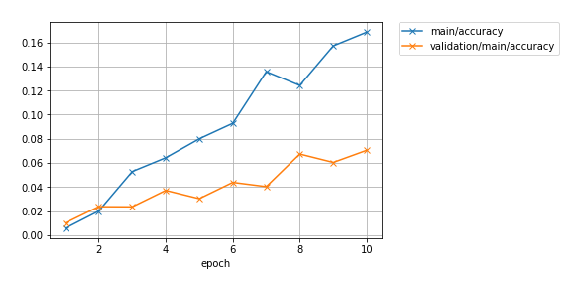

In [194]:
# 誤差と精度のグラフを描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [197]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred = model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [198]:
# 混同行列を出力
# testデータに対して行うことに注意
from sklearn.metrics import confusion_matrix as cm
result = predict(model, X_test)
cm(result, y_test)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [199]:
# 性能指標を確認
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.071


C:\Users\Jin Sakuma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


recall: 0.105


C:\Users\Jin Sakuma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.059
f1_score: 0.060


C:\Users\Jin Sakuma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Jin Sakuma\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
